
СХЕМА: AC × 4
Подтип: TNBC, Ki-67: 60.0%

Препараты и оптимальные дозы:
 • doxorubicin: базовая доза 60 mg/m2, множитель 1.30, номинальная 78.0 mg/m2, абсолютная ~78.0 mg, интервал q3w
 • cyclophosphamide: базовая доза 600 mg/m2, множитель 1.30, номинальная 780.0 mg/m2, абсолютная ~780.0 mg, интервал q3w


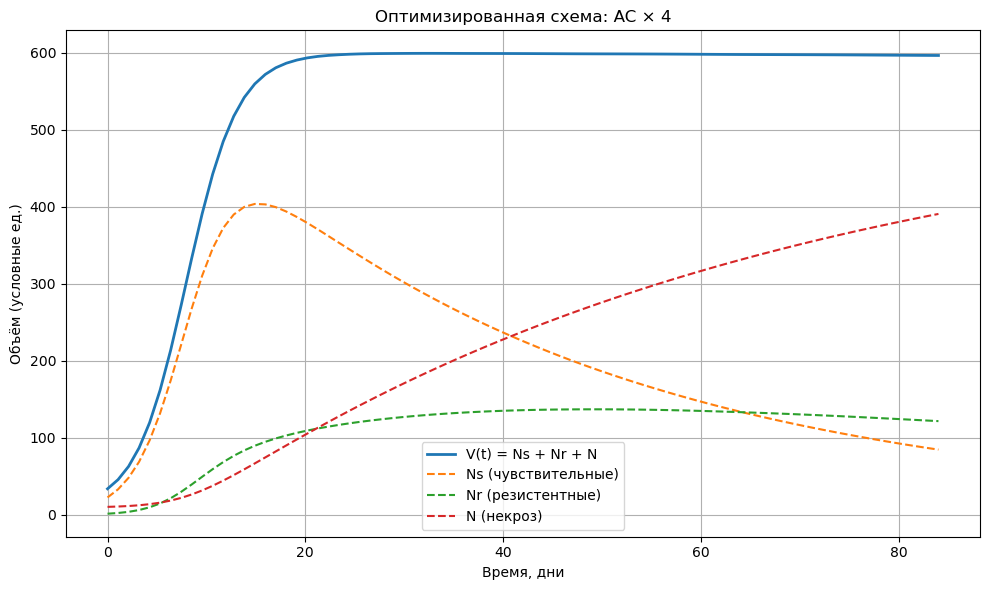

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

T_cycle_dict = {
    "HR+": 3.0, 
    "HER2+": 2.0,
    "TNBC": 1.0,
}

params_pop = {
    "HR+": {
        "d": 0.01,     
        "k_clear": 0.001,
        "K": 800.0,
        "f_N0": 0.2,   
    },
    "HER2+": {
        "d": 0.012,
        "k_clear": 0.001,
        "K": 700.0,
        "f_N0": 0.25,
    },
    "TNBC": {
        "d": 0.015,
        "k_clear": 0.0015,
        "K": 600.0,
        "f_N0": 0.3,
    },
}


def r_from_ki67(ki67_fraction, T_cycle_days):
    """
    Скорость деления r через Ki-67 и время клеточного цикла.
    ki67_fraction: доля (0–1)
    """
    return (np.log(2) / T_cycle_days) * ki67_fraction



PK_PD_PARAMS = {

    "docetaxel": {
        "dose_mg_per_m2": 75.0,
        "schedule": "q3w",
        "CL": 15.0,
        "Q": 10.0,
        "V1": 15.0,
        "V2": 40.0,
        "E_max": 0.35,
        "EC50": 0.5,
    },
    "cyclophosphamide": {
        "dose_mg_per_m2": 600.0,
        "schedule": "q3w",
        "CL": 10.0,
        "Q": 6.0,
        "V1": 20.0,
        "V2": 55.0,
        "E_max": 0.28,
        "EC50": 0.6,
    },
    "doxorubicin": {
        "dose_mg_per_m2": 60.0,
        "schedule": "q3w",
        "CL": 12.0,
        "Q": 8.0,
        "V1": 20.0,
        "V2": 50.0,
        "E_max": 0.40,
        "EC50": 0.4,
    },
    "paclitaxel": {
        "dose_mg_per_m2": 80.0,
        "schedule": "weekly",
        "CL": 20.0,
        "Q": 10.0,
        "V1": 15.0,
        "V2": 35.0,
        "E_max": 0.30,
        "EC50": 0.7,
    },
    "carboplatin": {
        "dose_mg_per_m2": 600.0,
        "schedule": "q3w",
        "CL": 10.0,
        "Q": 5.0,
        "V1": 20.0,
        "V2": 40.0,
        "E_max": 0.25,
        "EC50": 0.5,
    },


    "letrozole": {
        "dose_mg_fixed": 2.5,
        "schedule": "daily",
        "CL": 0.25,
        "Q": 0.0,
        "V1": 100.0,
        "V2": 0.0,
        "E_max": 0.12,
        "EC50": 0.05,
    },
    "tamoxifen": {
        "dose_mg_fixed": 20.0,
        "schedule": "daily",
        "CL": 0.2,
        "Q": 0.0,
        "V1": 120.0,
        "V2": 0.0,
        "E_max": 0.10,
        "EC50": 0.03,
    },
    "anastrozole": {
        "dose_mg_fixed": 1.0,
        "schedule": "daily",
        "CL": 0.15,
        "Q": 0.0,
        "V1": 80.0,
        "V2": 0.0,
        "E_max": 0.12,
        "EC50": 0.04,
    },
    "toremifene": {
        "dose_mg_fixed": 60.0,
        "schedule": "daily",
        "CL": 0.2,
        "Q": 0.0,
        "V1": 120.0,
        "V2": 0.0,
        "E_max": 0.10,
        "EC50": 0.03,
    },
    "fulvestrant": {
        "dose_mg_fixed": 500.0,
        "schedule": "q4w",
        "CL": 0.3,
        "Q": 0.0,
        "V1": 50.0,
        "V2": 0.0,
        "E_max": 0.15,
        "EC50": 0.05,
    },
    "buserelin": {
        "dose_mg_fixed": 3.75,
        "schedule": "q4w",
        "CL": 0.3,
        "Q": 0.0,
        "V1": 50.0,
        "V2": 0.0,
        "E_max": 0.10,
        "EC50": 0.05,
    },


    "trastuzumab_sc": {
        "dose_mg_fixed": 600.0,
        "schedule": "q3w",
        "CL": 0.5,
        "Q": 0.3,
        "V1": 3.0,
        "V2": 4.0,
        "E_max": 0.15,
        "EC50": 0.2,
    },
    "pertuzumab": {
        "dose_mg_fixed": 420.0,
        "schedule": "q3w",
        "CL": 0.5,
        "Q": 0.3,
        "V1": 3.0,
        "V2": 4.0,
        "E_max": 0.15,
        "EC50": 0.2,
    },
    "trastuzumab_emtansine": {
        "dose_mg_per_m2": 3.6,
        "schedule": "q3w",
        "CL": 0.5,
        "Q": 0.3,
        "V1": 3.0,
        "V2": 4.0,
        "E_max": 0.20,
        "EC50": 0.2,
    },


    "capecitabine": {
        "dose_mg_per_m2": 2000.0,
        "schedule": "q3w",  # упрощённо
        "CL": 15.0,
        "Q": 10.0,
        "V1": 30.0,
        "V2": 70.0,
        "E_max": 0.25,
        "EC50": 0.5,
    },
    "olaparib": {
        "dose_mg_fixed": 600.0,
        "schedule": "daily",
        "CL": 10.0,
        "Q": 5.0,
        "V1": 50.0,
        "V2": 0.0,
        "E_max": 0.20,
        "EC50": 0.3,
    },
}


def E_of_C(C, E_max, EC50):
    return E_max * C / (C + EC50 + 1e-12)


def pk_input_cycles(t, cycle_len=21.0, dose_amount=100.0):

    if abs(t % cycle_len) < 1e-6:
        return dose_amount
    return 0.0


def pk_one_comp_ode(t, y, CL, V1, input_func=None):
    A = y[0]
    I = input_func(t) if input_func else 0.0
    dA_dt = -(CL / V1) * A + I
    return [dA_dt]


def pk_two_comp_ode(t, y, CL, Q, V1, V2, input_func=None):
    A1, A2 = y
    I = input_func(t) if input_func else 0.0

    dA1dt = -(CL / V1) * A1 - (Q / V1) * A1 + (Q / V2) * A2 + I
    dA2dt = (Q / V1) * A1 - (Q / V2) * A2
    return [dA1dt, dA2dt]


def simulate_pk_two_comp(CL, Q, V1, V2, y0, t_end, n_points=2000, input_func=None):
    t_eval = np.linspace(0.0, t_end, 2000)

    sol = solve_ivp(
        lambda tt, yy: pk_two_comp_ode(tt, yy, CL, Q, V1, V2, input_func),
        [0.0, t_end],
        y0,
        t_eval=t_eval,
    )

    A1 = sol.y[0]
    C1 = A1 / V1
    C_interp = interp1d(t_eval, C1, fill_value="extrapolate")
    return C_interp


def build_single_drug_pkpd(
    drug_name,
    t_end=3650.0,
    bsa=1.7,
    dose_abs_override=None,
    schedule_override=None,
):

    if drug_name not in PK_PD_PARAMS:
        raise ValueError(f"Препарат {drug_name} отсутствует в PK_PD_PARAMS")

    p = PK_PD_PARAMS[drug_name]
    CL, Q, V1, V2 = p["CL"], p["Q"], p["V1"], p["V2"]
    is_one_comp = (Q == 0 or V2 == 0)
    E_max, EC50 = p["E_max"], p["EC50"]

    schedule = schedule_override if schedule_override is not None else p["schedule"]

    # доза
    if dose_abs_override is not None:
        dose_abs = dose_abs_override
    else:
        if "dose_mg_per_m2" in p:
            dose_abs = p["dose_mg_per_m2"] * bsa
        elif "dose_mg_fixed" in p:
            dose_abs = p["dose_mg_fixed"]
        else:
            raise ValueError(f"Не найдена доза для препарата {drug_name}")

    # интервал дозирования
    if schedule == "q3w":
        cycle = 21.0
    elif schedule == "q2w":
        cycle = 14.0
    elif schedule == "weekly":
        cycle = 7.0
    elif schedule == "daily":
        cycle = 1.0
    elif schedule == "q4w":
        cycle = 28.0
    elif schedule == "q6m":
        cycle = 180.0
    else:
        cycle = None  # разовая доза

    if cycle is not None:
        input_func = lambda tt, d=dose_abs, c=cycle: pk_input_cycles(tt, c, d)
        y0 = [0.0, 0.0]
    else:
        # однократный болюс в момент 0
        input_func = None
        y0 = [dose_abs, 0.0]

    # решение PK
    if is_one_comp:
        def pk_ode(tt, yy):
            return pk_one_comp_ode(tt, yy, CL, V1, input_func)

        t_eval = np.linspace(0.0, t_end, 2000)
        sol = solve_ivp(pk_ode, [0.0, t_end], [0.0], t_eval=t_eval)
        C = sol.y[0] / V1
        C_func = interp1d(t_eval, C, fill_value="extrapolate")
    else:
        C_func = simulate_pk_two_comp(
            CL, Q, V1, V2,
            y0=y0,
            t_end=t_end,
            n_points=2000,
            input_func=input_func,
        )

    return C_func, E_max, EC50


# ---------------------------------------------------------
# Словарь схем из фронтенда
# ---------------------------------------------------------

FRONTEND_REGIMENS = {
    "Летрозол": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "letrozole",
                "dose": 2.5,
                "unit": "mg",
                "interval": "daily",
                "n_cycles": 365,   # 1 год, упрощённо
            }
        ],
    },
    "Анастрозол": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "anastrozole",
                "dose": 1.0,
                "unit": "mg",
                "interval": "daily",
                "n_cycles": 365,
            }
        ],
    },
    "Фулвестрант": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "fulvestrant",
                "dose": 500.0,
                "unit": "mg",
                "interval": "q4w",
                "n_cycles": 12,   # 1 год
            }
        ],
    },
    "Бусерелин": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "buserelin",
                "dose": 3.75,
                "unit": "mg",
                "interval": "q4w",
                "n_cycles": 12,
            }
        ],
    },
    "Торемифен": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "toremifene",
                "dose": 60.0,
                "unit": "mg",
                "interval": "daily",
                "n_cycles": 365,
            }
        ],
    },
    "Тамоксифен → ингибиторы ароматазы": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 3 * 365,
                "drugs": [
                    {
                        "pk_name": "tamoxifen",
                        "dose": 20.0,
                        "unit": "mg",
                        "interval": "daily",
                    }
                ],
            },
            {
                "duration_days": 2 * 365,
                "drugs": [
                    {
                        "pk_name": "letrozole",   # упрощённо, как один из ИА
                        "dose": 2.5,
                        "unit": "mg",
                        "interval": "daily",
                    }
                ],
            },
        ],
    },

    # --- HER2-положительные / отрицательные режимы из одного списка ---
    "(DC + трастузумаб) × 4–6": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 6 * 21,
                "drugs": [
                    {"pk_name": "docetaxel", "dose": 75, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "q3w"},
                ],
            }
        ],
    },
    "DCН × 6": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 6 * 21,
                "drugs": [
                    {"pk_name": "docetaxel", "dose": 75, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "carboplatin", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "q3w"},
                ],
            }
        ],
    },
    "DCН + пертузумаб × 6": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 6 * 21,
                "drugs": [
                    {"pk_name": "docetaxel", "dose": 75, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "carboplatin", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "q3w"},
                    {"pk_name": "pertuzumab", "dose": 420, "unit": "mg", "interval": "q3w"},
                ],
            }
        ],
    },
    "(Р + трастузумаб) × 12": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 12 * 7,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 80, "unit": "mg/m2", "interval": "weekly"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "weekly"},
                ],
            }
        ],
    },
    "AC × 4 → (D + трастузумаб) × 4": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                ],
            },
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "docetaxel", "dose": 75, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "q3w"},
                ],
            },
        ],
    },
    "AC × 4 → (Р + трастузумаб) × 12": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                ],
            },
            {
                "duration_days": 12 * 7,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 80, "unit": "mg/m2", "interval": "weekly"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "weekly"},
                ],
            },
        ],
    },
    "ddAC × 4 → (Р + трастузумаб) × 12": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q2w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q2w"},
                ],
            },
            {
                "duration_days": 12 * 7,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 80, "unit": "mg/m2", "interval": "weekly"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "weekly"},
                ],
            },
        ],
    },
    "ddАС × 4 → (Р + трастузумаб) × 4": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q2w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q2w"},
                ],
            },
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 175, "unit": "mg/m2", "interval": "q2w"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "q2w"},
                ],
            },
        ],
    },
    "АС × 4 → (таксаны+ трастузумаб + пертузумаб) × 4": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                ],
            },
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "docetaxel", "dose": 75, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "trastuzumab_sc", "dose": 600, "unit": "mg", "interval": "q3w"},
                    {"pk_name": "pertuzumab", "dose": 420, "unit": "mg", "interval": "q3w"},
                ],
            },
        ],
    },
    "Трастузумаб эмтанзин × 14": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "trastuzumab_emtansine",
                "dose": 3.6,
                "unit": "mg/m2",
                "interval": "q3w",
                "n_cycles": 14,
            }
        ],
    },


    "ddАС × 4 → ddP × 4 АС": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q2w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q2w"},
                ],
            },
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 175, "unit": "mg/m2", "interval": "q2w"},
                ],
            },
        ],
    },
    "ddАC × 4 → P × 12 АС": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q2w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q2w"},
                ],
            },
            {
                "duration_days": 12 * 7,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 80, "unit": "mg/m2", "interval": "weekly"},
                ],
            },
        ],
    },
    "ddАC × 4 → P + С × 12 АС": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 14,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q2w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q2w"},
                ],
            },
            {
                "duration_days": 12 * 7,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 80, "unit": "mg/m2", "interval": "weekly"},
                    {"pk_name": "carboplatin", "dose": 300, "unit": "mg/m2", "interval": "weekly"},
                ],
            },
        ],
    },
    "DC × 4–6": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "docetaxel",
                "dose": 75,
                "unit": "mg/m2",
                "interval": "q3w",
                "n_cycles": 6,
            },
            {
                "pk_name": "cyclophosphamide",
                "dose": 600,
                "unit": "mg/m2",
                "interval": "q3w",
                "n_cycles": 6,
            },
        ],
    },
    "AC × 4": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "doxorubicin",
                "dose": 60,
                "unit": "mg/m2",
                "interval": "q3w",
                "n_cycles": 4,
            },
            {
                "pk_name": "cyclophosphamide",
                "dose": 600,
                "unit": "mg/m2",
                "interval": "q3w",
                "n_cycles": 4,
            },
        ],
    },
    "AC × 4 → D × 4": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                ],
            },
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "docetaxel", "dose": 75, "unit": "mg/m2", "interval": "q3w"},
                ],
            },
        ],
    },
    "AC × 4 → P × 12": {
        "type": "phased",
        "phases": [
            {
                "duration_days": 4 * 21,
                "drugs": [
                    {"pk_name": "doxorubicin", "dose": 60, "unit": "mg/m2", "interval": "q3w"},
                    {"pk_name": "cyclophosphamide", "dose": 600, "unit": "mg/m2", "interval": "q3w"},
                ],
            },
            {
                "duration_days": 12 * 7,
                "drugs": [
                    {"pk_name": "paclitaxel", "dose": 80, "unit": "mg/m2", "interval": "weekly"},
                ],
            },
        ],
    },
    "Капецитабин (монотерапия)": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "capecitabine",
                "dose": 2000,
                "unit": "mg/m2",
                "interval": "q3w",  
                "n_cycles": 8,
            }
        ],
    },
    "Олапариб": {
        "type": "simple",
        "drugs": [
            {
                "pk_name": "olaparib",
                "dose": 600,
                "unit": "mg",
                "interval": "daily",
                "n_cycles": 365,
            }
        ],
    },
}


INTERVAL_TO_DAYS = {
    "q3w": 21.0,
    "q2w": 14.0,
    "weekly": 7.0,
    "daily": 1.0,
    "q4w": 28.0,
    "q6m": 180.0,
}


def get_regimen_length_days_from_frontend(regimen_name):

    reg = FRONTEND_REGIMENS[regimen_name]
    rtype = reg["type"]

    if rtype == "simple":
        max_len = 0.0
        for d in reg["drugs"]:
            interval = d["interval"]
            n_cycles = d.get("n_cycles", 1)
            dt = INTERVAL_TO_DAYS.get(interval, 21.0)
            max_len = max(max_len, n_cycles * dt)
        if max_len <= 0:
            max_len = 365.0
        return max_len

    elif rtype == "phased":
        total = 0.0
        for phase in reg["phases"]:
            total += float(phase["duration_days"])
        if total <= 0:
            total = 365.0
        return total

    else:
        return 365.0



def tumor_ode_resistant(t, y,
                        r, K, d_base, k_clear,
                        drug_effect_func,
                        mutation_rate,
                        resistance_strength):

    Ns, Nr, N = y
    drug = drug_effect_func(t) if drug_effect_func is not None else 0.0

    death_s = (d_base + drug) * Ns
    death_r = (d_base + drug * resistance_strength) * Nr

    mut = mutation_rate * Ns
    U_total = Ns + Nr

    growth_s = r * Ns * (1.0 - (U_total + N) / K)
    growth_r = r * Nr * (1.0 - (U_total + N) / K)

    dNsdt = growth_s - death_s - mut
    dNrdt = growth_r - death_r + mut
    dNdt = death_s + death_r - k_clear * N

    return [dNsdt, dNrdt, dNdt]


def simulate_patient_resistant(subtype,
                               ki67_percent,
                               V0,
                               drug_effect_func,
                               t_end=365.0,
                               mutation_rate=0.01,
                               resistance_strength=0.5,
                               bsa=1.7):

    if subtype not in params_pop:
        raise ValueError(f"Неизвестный подтип {subtype}")

    pop = params_pop[subtype]
    T_cycle = T_cycle_dict[subtype]

    d_base = pop["d"]
    k_clear = pop["k_clear"]
    K = pop["K"]
    f_N0 = pop["f_N0"]

    r = r_from_ki67(ki67_percent / 100.0, T_cycle)

    t_eval = np.linspace(0.0, t_end, 80)

    U0 = (1.0 - f_N0) * V0
    Ns0 = U0 * 0.95
    Nr0 = U0 * 0.05
    N0 = f_N0 * V0
    y0 = [Ns0, Nr0, N0]

    sol = solve_ivp(
        lambda tt, yy: tumor_ode_resistant(
            tt, yy,
            r=r, K=K,
            d_base=d_base, k_clear=k_clear,
            drug_effect_func=drug_effect_func,
            mutation_rate=mutation_rate,
            resistance_strength=resistance_strength,
        ),
        [0.0, t_end],
        y0,
        t_eval=t_eval,
    )

    Ns, Nr, N = sol.y
    V = Ns + Nr + N
    return t_eval, V, Ns, Nr, N



DEFAULT_DOSE_SCALES = [0.7, 0.85, 1.0, 1.15, 1.3]


def _compute_absolute_dose(base_dose, unit, scale):
    return base_dose * scale



def to_volume_from_diameter(d_cm):
    """Перевод диаметра в объем (сфера)."""
    return (np.pi / 6.0) * (d_cm ** 3)


def to_diameter_from_volume(V):
    """Перевод объёма в диаметр (обратная операция)."""
    return (6.0 * V / np.pi) ** (1.0 / 3.0)



def make_drug_effect_from_frontend(regimen_name,
                                   dose_multipliers,
                                   t_end,
                                   bsa=1.7):

    if regimen_name not in FRONTEND_REGIMENS:
        raise ValueError(f"Схема {regimen_name} не найдена во FRONTEND_REGIMENS")

    reg = FRONTEND_REGIMENS[regimen_name]
    rtype = reg["type"]

    pk_list = [] 

    if rtype == "simple":
        for d in reg["drugs"]:
            pk_name = d["pk_name"]
            base_dose = d["dose"]
            unit = d["unit"]
            interval = d["interval"]

            scale = dose_multipliers.get(pk_name, 1.0)
            dose_abs = _compute_absolute_dose(base_dose, unit, scale)

            C_func, E_max, EC50 = build_single_drug_pkpd(
                drug_name=pk_name,
                t_end=t_end,
                bsa=bsa,
                dose_abs_override=dose_abs,
                schedule_override=interval,
            )
            pk_list.append((C_func, E_max, EC50))

    elif rtype == "phased":
        t_shift = 0.0
        for phase in reg["phases"]:
            duration = float(phase["duration_days"])
            for d in phase["drugs"]:
                pk_name = d["pk_name"]
                base_dose = d["dose"]
                unit = d["unit"]
                interval = d["interval"]

                scale = dose_multipliers.get(pk_name, 1.0)
                dose_abs = _compute_absolute_dose(base_dose, unit, scale)

                C_phase, E_max, EC50 = build_single_drug_pkpd(
                    drug_name=pk_name,
                    t_end=duration,
                    bsa=bsa,
                    dose_abs_override=dose_abs,
                    schedule_override=interval,
                )

                def make_shifted(C_local, shift):
                    def C_global(t):
                        tau = t - shift
                        if tau < 0:
                            return 0.0
                        return float(C_local(max(tau, 0.0)))
                    return C_global

                C_shifted = make_shifted(C_phase, t_shift)
                pk_list.append((C_shifted, E_max, EC50))

            t_shift += duration
    else:
        raise ValueError(f"Неизвестный тип схемы {rtype}")

    def drug_effect(t):
        total = 0.0
        for C_func, E_max, EC50 in pk_list:
            C = float(C_func(t))
            total += E_of_C(C, E_max, EC50)
        return total

    return drug_effect



def optimize_frontend_regimen(regimen_name,
                              subtype,
                              ki67_percent,
                              V0,
                              bsa=1.7,
                              dose_scales=None,
                              objective="min_final_volume",
                              mutation_rate=0.01,
                              resistance_strength=0.5):

    if dose_scales is None:
        dose_scales = DEFAULT_DOSE_SCALES

    reg = FRONTEND_REGIMENS[regimen_name]
    rtype = reg["type"]

    # собрать pk-имена
    pk_names = []
    if rtype == "simple":
        for d in reg["drugs"]:
            if d["pk_name"] not in pk_names:
                pk_names.append(d["pk_name"])
    else:
        for phase in reg["phases"]:
            for d in phase["drugs"]:
                if d["pk_name"] not in pk_names:
                    pk_names.append(d["pk_name"])

    # длительность схемы
    t_end = get_regimen_length_days_from_frontend(regimen_name)

    best_score = np.inf
    best_result = None

    for combo in product(dose_scales, repeat=len(pk_names)):
        dose_multipliers = dict(zip(pk_names, combo))

        drug_eff = make_drug_effect_from_frontend(
            regimen_name=regimen_name,
            dose_multipliers=dose_multipliers,
            t_end=t_end,
            bsa=bsa,
        )

        t, V, Ns, Nr, N = simulate_patient_resistant(
            subtype=subtype,
            ki67_percent=ki67_percent,
            V0=V0,
            drug_effect_func=drug_eff,
            t_end=t_end,
            mutation_rate=mutation_rate,
            resistance_strength=resistance_strength,
            bsa=bsa,
        )

        score = V[-1] if objective == "min_final_volume" else np.min(V)

        if score < best_score:
            best_score = score
            best_result = {
                "regimen_name": regimen_name,
                "dose_multipliers": dose_multipliers,
                "t": t,
                "V": V,
                "Ns": Ns,
                "Nr": Nr,
                "N": N,
                "score": score,
                "t_end": t_end,
            }

    return best_result


# ---------------------------------------------------------
# Вывод результатов и графики
# ---------------------------------------------------------

def summarize_and_plot_frontend_result(result,
                                       subtype,
                                       ki67_percent,
                                       V0,
                                       bsa=1.7,
                                       plot=True):

    if result is None:
        print("❌ Не удалось найти ни одной допустимой комбинации доз.")
        return

    regimen_name = result["regimen_name"]
    dose_multipliers = result["dose_multipliers"]
    t = np.array(result["t"])
    V = np.array(result["V"])
    Ns = np.array(result["Ns"])
    Nr = np.array(result["Nr"])
    N = np.array(result["N"])

    reg = FRONTEND_REGIMENS[regimen_name]
    rtype = reg["type"]

    print("\n" + "=" * 70)
    print(f"СХЕМА: {regimen_name}")
    print("=" * 70)
    print(f"Подтип: {subtype}, Ki-67: {ki67_percent}%")

    print("\nПрепараты и оптимальные дозы:")
    printed = set()

    def print_drug(pk_name, base_dose, unit, interval):
        if pk_name in printed:
            return
        printed.add(pk_name)
        scale = dose_multipliers.get(pk_name, 1.0)
        dose_opt = base_dose * scale
        abs_opt = _compute_absolute_dose(base_dose, unit, scale)
        print(
            f" • {pk_name}: базовая доза {base_dose} {unit}, "
            f"множитель {scale:.2f}, "
            f"номинальная {dose_opt:.1f} {unit}, "
            f"абсолютная ~{abs_opt:.1f} mg, интервал {interval}"
        )

    if rtype == "simple":
        for d in reg["drugs"]:
            print_drug(d["pk_name"], d["dose"], d["unit"], d["interval"])
    elif rtype == "phased":
        for phase in reg["phases"]:
            for d in phase["drugs"]:
                print_drug(d["pk_name"], d["dose"], d["unit"], d["interval"])

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(t, V, label="V(t) = Ns + Nr + N", linewidth=2)
        plt.plot(t, Ns, "--", label="Ns (чувствительные)")
        plt.plot(t, Nr, "--", label="Nr (резистентные)")
        plt.plot(t, N,  "--", label="N (некроз)")
        plt.xlabel("Время, дни")
        plt.ylabel("Объём (условные ед.)")
        plt.title(f"Оптимизированная схема: {regimen_name}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("=" * 70 + "\n")


def run_simulation_for_backend(params: dict) -> dict:


    subtype = params["subtype"]
    ki67 = params["ki67"]
    tumor_size_cm = params["tumor_size_cm"]
    regimen = params["regimen"]

    bsa = params.get("bsa", 1.7)

    # перевод размера опухоли в объём
    V0 = to_volume_from_diameter(tumor_size_cm)

    # оптимизация доз
    best = optimize_frontend_regimen(
        regimen_name=regimen,
        subtype=subtype,
        ki67_percent=ki67,
        V0=V0,
        bsa=bsa,
    )

    if best is None:
        return {
            "error": "no_solution",
            "message": "Не удалось найти комбинацию доз"
        }

    # базовый json-ответ: только метаданные пациента + кривые для графика
    result = {
        "regimen": regimen,
        "subtype": subtype,
        "ki67": ki67,
        "tumor_size_cm": tumor_size_cm,
        "t": best["t"].tolist(),
        "V": best["V"].tolist(),
        "Ns": best["Ns"].tolist(),
        "Nr": best["Nr"].tolist(),
        "N": best["N"].tolist(),
        "dose_multipliers": best["dose_multipliers"],
        "t_end": best["t_end"],
    }


    absolute_doses = {}
    regimen_info = FRONTEND_REGIMENS[regimen]
    rtype = regimen_info["type"]

    base_doses = {}
    base_units = {}
    intervals = {}

    if rtype == "simple":
        for d in regimen_info["drugs"]:
            pk = d["pk_name"]
            base_doses[pk] = d["dose"]
            base_units[pk] = d["unit"]
            intervals[pk] = d["interval"]

    elif rtype == "phased":
        for ph in regimen_info["phases"]:
            for d in ph["drugs"]:
                pk = d["pk_name"]
                if pk not in base_doses:
                    base_doses[pk] = d["dose"]
                    base_units[pk] = d["unit"]
                    intervals[pk] = d["interval"]

    for pk, m in best["dose_multipliers"].items():
        abs_dose = _compute_absolute_dose(base_doses[pk], base_units[pk], bsa, m)
        absolute_doses[pk] = {
            "multiplier": m,
            "absolute_mg": abs_dose,
            "base_dose": base_doses[pk],
            "unit": base_units[pk],
            "interval": intervals[pk],
        }

    result["absolute_doses"] = absolute_doses

    best["optimized_usual_doses"] = {}
    regimen_info = FRONTEND_REGIMENS[regimen_name]

    if regimen_info["type"] == "simple":
        drugs = regimen_info["drugs"]
    elif regimen_info["type"] == "phased":
        # только уникальные препараты
        drugs = []
        for ph in regimen_info["phases"]:
            for d in ph["drugs"]:
                if d["pk_name"] not in [x["pk_name"] for x in drugs]:
                    drugs.append(d)

    for d in drugs:
        pk = d["pk_name"]
        base = d["dose"]
        m = best["dose_multipliers"][pk]
        best["optimized_usual_doses"][pk] = base * m


    return result


if __name__ == "__main__":
    subtype = "TNBC"
    ki67 = 60.0
    d0_cm = 4.0
    V0_example = to_volume_from_diameter(d0_cm)

    regimen_key = "AC × 4"

    best = optimize_frontend_regimen(
        regimen_name=regimen_key,
        subtype=subtype,
        ki67_percent=ki67,
        V0=V0_example,
    )

    summarize_and_plot_frontend_result(
        best,
        subtype=subtype,
        ki67_percent=ki67,
        V0=V0_example,
    )

    


In [94]:
def run_simulation_for_backend(params: dict) -> dict:

    subtype = params["subtype"]
    ki67 = params["ki67"]
    tumor_size_cm = params["tumor_size_cm"]
    regimen = params["regimen"]

    V0 = to_volume_from_diameter(tumor_size_cm)

    best = optimize_frontend_regimen(
        regimen_name=regimen,
        subtype=subtype,
        ki67_percent=ki67,
        V0=V0,
    )

    if best is None:
        return {
            "ok": False,
            "t": None,
            "V": None,
            "Ns": None,
            "Nr": None,
            "N": None
        }
    
    result = {
        "ok": True,
        "t": best["t"].tolist(),
        "V": best["V"].tolist(),
        "Ns": best["Ns"].tolist(),
        "Nr": best["Nr"].tolist(),
        "N": best["N"].tolist()
    }

    regimen_info = FRONTEND_REGIMENS[regimen]
    rtype = regimen_info["type"]

    base_doses = {}
    base_units = {}
    intervals = {}

    if rtype == "simple":
        for d in regimen_info["drugs"]:
            pk = d["pk_name"]
            base_doses[pk] = d["dose"]
            base_units[pk] = d["unit"]
            intervals[pk] = d["interval"]

    elif rtype == "phased":
        seen = set()
        for ph in regimen_info["phases"]:
            for d in ph["drugs"]:
                pk = d["pk_name"]
                if pk not in seen:
                    seen.add(pk)
                    base_doses[pk] = d["dose"]
                    base_units[pk] = d["unit"]
                    intervals[pk] = d["interval"]

    final_doses = {}

    for pk in base_doses.keys():
        m = best["dose_multipliers"][pk]     # множитель дозировки
        base = base_doses[pk]
        optimized = base * m                 # → MG или MG/M2, НЕ абсолютная доза

        final_doses[pk] = {
            "base_dose": base,
            "optimized_dose": optimized,
        }

    result["doses"] = final_doses

    return result


In [95]:
params_pop.keys()

dict_keys(['HR+', 'HER2+', 'TNBC'])

In [96]:
def subtype_from_markers(er_status: bool, pr_status: bool, her2_status: bool) -> str:
    if her2_status:
        return "HER2+"
    if er_status or pr_status:
        return "HR+"
    return "TNBC"


In [97]:
subtype_from_markers(True, False, False)   # HR+
subtype_from_markers(False, False, True)   # HER2+
subtype_from_markers(False, False, False)  # TNBC
subtype_from_markers(True, True, False)    # HR+


'HR+'

In [98]:
params = {
    "subtype": "TNBC",          # ['HR+', 'HER2+', 'TNBC']
    "ki67": 60,
    "tumor_size_cm": 4.0,
    "regimen": "AC × 4",
}
res = run_simulation_for_backend(params)

In [ ]:
res

{'ok': True,
 't': [0.0,
  1.0632911392405062,
  2.1265822784810124,
  3.1898734177215187,
  4.253164556962025,
  5.3164556962025316,
  6.379746835443037,
  7.443037974683543,
  8.50632911392405,
  9.569620253164556,
  10.632911392405063,
  11.696202531645568,
  12.759493670886075,
  13.822784810126581,
  14.886075949367086,
  15.949367088607593,
  17.0126582278481,
  18.075949367088604,
  19.139240506329113,
  20.202531645569618,
  21.265822784810126,
  22.32911392405063,
  23.392405063291136,
  24.455696202531644,
  25.51898734177215,
  26.582278481012654,
  27.645569620253163,
  28.708860759493668,
  29.772151898734172,
  30.83544303797468,
  31.898734177215186,
  32.962025316455694,
  34.0253164556962,
  35.088607594936704,
  36.15189873417721,
  37.21518987341772,
  38.278481012658226,
  39.34177215189873,
  40.405063291139236,
  41.46835443037974,
  42.53164556962025,
  43.59493670886076,
  44.65822784810126,
  45.72151898734177,
  46.78481012658227,
  47.84810126582278,
  48.911